In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [3]:
# Import data 
assay = 'nor_package'  # nor_package
array = 'seq'    #  RNA


df_all = pd.read_csv('../data/2nd_10209_Package_seq.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['seq', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','seq'])
df = df.iloc[::50]
df

,seq,nor_package
6135,CAGGGTTGGTTTTATCTGCAT,0.000000
8050,AAGATGCGTTTGTGTAGGTGT,0.004044
9126,GGTGGGTGGATTCTTTGTTGG,0.006525
1845,TGTATGGTGACTAATTGGGGG,0.010300
4374,AAGACTTGTGGGTTTATTATT,0.018075
...,...,...
3605,GCTGTGAAGAGTGATGCGAGG,1.615085
5023,CTTACGCAGTCTGGTGTTTCG,1.639426
12,CGTGAGAAGGTGGTTGGTCAT,1.682482
5812,CGTATGAATGAGAGGCAGGAT,1.734835


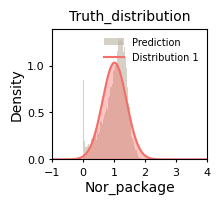

In [4]:
nor_package = df_all[np.isfinite(df_all[assay])][assay]
data = np.array(nor_package) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 5, 10000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-1, 0, 1,2,3,4]); 
ax.set_xlim([-1,4])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [5]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array,target_assay_col=assay)
train_df['Y--nor_package'] = train_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])
test_df['Y--nor_package'] = test_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])
prepped_df['Y--nor_package'] = prepped_df['seq'].map(df.drop_duplicates('seq').set_index('seq')['nor_package'])

Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [6]:
X, Y = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

## SVAE training

Default parameterization (used in paper):

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [7]:
# SVAE parameters (same as default)
input_dim = 420
latent_dim = 2
enc_hidden_dims = [300,120]
dec_hidden_dims = [120,300]
reg_hidden_dims = [300,30]

# training parameters 
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

outpath = 'pretrain/model_2nd_seq_nor_package'

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=420, latent_dim=6, enc_hidden_dims=[300,120], dec_hidden_dims=[120,300], reg_hidden_dims=[300,30], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 420)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  163872    ['encoder_input[0][0]',       
                              (None, 6),                             'encoder_input[0][0]']       
                              (None, 6)]                                                          
                                                                                                  
 tf.concat_1 (TFOpLambda)    (None, 426)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [8]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,train_df, 
                        optimizer=optimizer,
                        loss_weights=loss_weights           
                        )


Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
84/84 [==============================] - 1s 16ms/step - train_model_loss: 55.9282 - train_reconstruction_loss: 53.3989 - train_kl_loss: 0.7341 - train_regression_loss: 1.2909 - val_model_loss: 34.3816 - val_reconstruction_loss: 26.9562 - val_kl_loss: 1.1817 - val_regression_loss: 4.5331
INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 2
84/84 [==============================] - 1s 14ms/step - train_model_loss: 29.5337 - train_reconstruction_loss: 26.6297 - train_kl_loss: 0.7349 - train_regression_loss: 1.3396 - val_model_loss: 31.3203 - val_reconstruction_loss: 30.4322 - val_kl_loss: 0.3329 - val_regression_loss: 0.4620


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 3
84/84 [==============================] - 1s 14ms/step - train_model_loss: 30.5416 - train_reconstruction_loss: 29.0926 - train_kl_loss: 0.6305 - train_regression_loss: 0.5499 - val_model_loss: 26.3120 - val_reconstruction_loss: 25.6147 - val_kl_loss: 0.5713 - val_regression_loss: 0.1762


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 4
84/84 [==============================] - 1s 14ms/step - train_model_loss: 28.3204 - train_reconstruction_loss: 27.5396 - train_kl_loss: 0.5574 - train_regression_loss: 0.2248 - val_model_loss: 26.3448 - val_reconstruction_loss: 25.4767 - val_kl_loss: 0.5968 - val_regression_loss: 0.2287


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 5
84/84 [==============================] - 1s 17ms/step - train_model_loss: 25.0695 - train_reconstruction_loss: 24.3643 - train_kl_loss: 0.5577 - train_regression_loss: 0.1507 - val_model_loss: 24.1895 - val_reconstruction_loss: 23.5716 - val_kl_loss: 0.5534 - val_regression_loss: 0.0961


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 6
84/84 [==============================] - 1s 17ms/step - train_model_loss: 24.7680 - train_reconstruction_loss: 24.0648 - train_kl_loss: 0.6010 - train_regression_loss: 0.1406 - val_model_loss: 23.2058 - val_reconstruction_loss: 22.2716 - val_kl_loss: 0.6603 - val_regression_loss: 0.2059


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 7
84/84 [==============================] - 1s 14ms/step - train_model_loss: 23.8678 - train_reconstruction_loss: 23.2327 - train_kl_loss: 0.5093 - train_regression_loss: 0.1458 - val_model_loss: 23.9552 - val_reconstruction_loss: 23.5159 - val_kl_loss: 0.3058 - val_regression_loss: 0.1231


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 8
84/84 [==============================] - 1s 15ms/step - train_model_loss: 23.7194 - train_reconstruction_loss: 23.2326 - train_kl_loss: 0.3351 - train_regression_loss: 0.1377 - val_model_loss: 23.7532 - val_reconstruction_loss: 23.3016 - val_kl_loss: 0.3497 - val_regression_loss: 0.1109


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 9
84/84 [==============================] - 1s 14ms/step - train_model_loss: 23.3870 - train_reconstruction_loss: 22.9314 - train_kl_loss: 0.3530 - train_regression_loss: 0.1068 - val_model_loss: 23.7167 - val_reconstruction_loss: 23.2640 - val_kl_loss: 0.3711 - val_regression_loss: 0.1212


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 10
84/84 [==============================] - 1s 14ms/step - train_model_loss: 23.1592 - train_reconstruction_loss: 22.7333 - train_kl_loss: 0.3114 - train_regression_loss: 0.0986 - val_model_loss: 23.3865 - val_reconstruction_loss: 22.9298 - val_kl_loss: 0.2955 - val_regression_loss: 0.0993


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 11
84/84 [==============================] - 1s 15ms/step - train_model_loss: 23.2494 - train_reconstruction_loss: 22.8674 - train_kl_loss: 0.2818 - train_regression_loss: 0.1105 - val_model_loss: 22.9632 - val_reconstruction_loss: 22.5386 - val_kl_loss: 0.3011 - val_regression_loss: 0.1014


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 12
84/84 [==============================] - 1s 14ms/step - train_model_loss: 23.1430 - train_reconstruction_loss: 22.7687 - train_kl_loss: 0.2746 - train_regression_loss: 0.0948 - val_model_loss: 22.6068 - val_reconstruction_loss: 22.3047 - val_kl_loss: 0.2496 - val_regression_loss: 0.0528


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 13
84/84 [==============================] - 1s 15ms/step - train_model_loss: 22.5847 - train_reconstruction_loss: 22.2115 - train_kl_loss: 0.2701 - train_regression_loss: 0.1025 - val_model_loss: 22.4690 - val_reconstruction_loss: 22.1455 - val_kl_loss: 0.2613 - val_regression_loss: 0.0828


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 14
84/84 [==============================] - 2s 19ms/step - train_model_loss: 22.6357 - train_reconstruction_loss: 22.2569 - train_kl_loss: 0.2903 - train_regression_loss: 0.1289 - val_model_loss: 22.3834 - val_reconstruction_loss: 21.9466 - val_kl_loss: 0.3342 - val_regression_loss: 0.1165


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 15
84/84 [==============================] - 1s 16ms/step - train_model_loss: 22.5676 - train_reconstruction_loss: 22.1858 - train_kl_loss: 0.2987 - train_regression_loss: 0.0824 - val_model_loss: 22.4240 - val_reconstruction_loss: 21.9957 - val_kl_loss: 0.2866 - val_regression_loss: 0.1596


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 16
84/84 [==============================] - 2s 18ms/step - train_model_loss: 22.6220 - train_reconstruction_loss: 22.2501 - train_kl_loss: 0.2894 - train_regression_loss: 0.0793 - val_model_loss: 23.0703 - val_reconstruction_loss: 22.6893 - val_kl_loss: 0.2940 - val_regression_loss: 0.0720


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 17
84/84 [==============================] - 1s 16ms/step - train_model_loss: 22.2900 - train_reconstruction_loss: 21.9184 - train_kl_loss: 0.3010 - train_regression_loss: 0.0789 - val_model_loss: 21.7608 - val_reconstruction_loss: 21.3438 - val_kl_loss: 0.3698 - val_regression_loss: 0.1074


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 18
84/84 [==============================] - 1s 17ms/step - train_model_loss: 22.3359 - train_reconstruction_loss: 21.9315 - train_kl_loss: 0.3368 - train_regression_loss: 0.0880 - val_model_loss: 22.4108 - val_reconstruction_loss: 22.0667 - val_kl_loss: 0.2953 - val_regression_loss: 0.0653


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 19
84/84 [==============================] - 1s 18ms/step - train_model_loss: 22.1818 - train_reconstruction_loss: 21.7986 - train_kl_loss: 0.3119 - train_regression_loss: 0.0833 - val_model_loss: 22.3031 - val_reconstruction_loss: 21.9148 - val_kl_loss: 0.3160 - val_regression_loss: 0.0962


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 20
84/84 [==============================] - 1s 17ms/step - train_model_loss: 22.0153 - train_reconstruction_loss: 21.6000 - train_kl_loss: 0.3418 - train_regression_loss: 0.1059 - val_model_loss: 21.7942 - val_reconstruction_loss: 21.3624 - val_kl_loss: 0.3617 - val_regression_loss: 0.0824


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 21
84/84 [==============================] - 1s 18ms/step - train_model_loss: 22.1742 - train_reconstruction_loss: 21.7741 - train_kl_loss: 0.3499 - train_regression_loss: 0.0816 - val_model_loss: 22.4298 - val_reconstruction_loss: 22.0556 - val_kl_loss: 0.3129 - val_regression_loss: 0.0744


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 22
84/84 [==============================] - 2s 19ms/step - train_model_loss: 21.8549 - train_reconstruction_loss: 21.4340 - train_kl_loss: 0.3542 - train_regression_loss: 0.0816 - val_model_loss: 21.8852 - val_reconstruction_loss: 21.4386 - val_kl_loss: 0.3857 - val_regression_loss: 0.1197


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 23
84/84 [==============================] - 1s 15ms/step - train_model_loss: 21.9994 - train_reconstruction_loss: 21.5481 - train_kl_loss: 0.3989 - train_regression_loss: 0.1051 - val_model_loss: 21.7008 - val_reconstruction_loss: 21.2322 - val_kl_loss: 0.3740 - val_regression_loss: 0.0846


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 24
84/84 [==============================] - 1s 14ms/step - train_model_loss: 21.7411 - train_reconstruction_loss: 21.2893 - train_kl_loss: 0.3716 - train_regression_loss: 0.1103 - val_model_loss: 21.9231 - val_reconstruction_loss: 21.5068 - val_kl_loss: 0.4022 - val_regression_loss: 0.0560


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 25
84/84 [==============================] - 1s 15ms/step - train_model_loss: 21.4353 - train_reconstruction_loss: 21.0025 - train_kl_loss: 0.3772 - train_regression_loss: 0.0746 - val_model_loss: 21.6682 - val_reconstruction_loss: 21.1730 - val_kl_loss: 0.3835 - val_regression_loss: 0.1085


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 26
84/84 [==============================] - 1s 17ms/step - train_model_loss: 21.6751 - train_reconstruction_loss: 21.2201 - train_kl_loss: 0.4067 - train_regression_loss: 0.0833 - val_model_loss: 21.4047 - val_reconstruction_loss: 20.9374 - val_kl_loss: 0.4199 - val_regression_loss: 0.1055


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 27
84/84 [==============================] - 1s 14ms/step - train_model_loss: 21.4602 - train_reconstruction_loss: 20.9927 - train_kl_loss: 0.4224 - train_regression_loss: 0.0873 - val_model_loss: 21.2168 - val_reconstruction_loss: 20.7079 - val_kl_loss: 0.4221 - val_regression_loss: 0.1214


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 28
84/84 [==============================] - 1s 18ms/step - train_model_loss: 21.6563 - train_reconstruction_loss: 21.2021 - train_kl_loss: 0.4106 - train_regression_loss: 0.0696 - val_model_loss: 21.7768 - val_reconstruction_loss: 21.3344 - val_kl_loss: 0.4391 - val_regression_loss: 0.0746


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 29
84/84 [==============================] - 1s 16ms/step - train_model_loss: 21.8953 - train_reconstruction_loss: 21.4431 - train_kl_loss: 0.4313 - train_regression_loss: 0.0729 - val_model_loss: 21.5236 - val_reconstruction_loss: 21.0261 - val_kl_loss: 0.4560 - val_regression_loss: 0.0827


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.

epoch 30
84/84 [==============================] - 1s 15ms/step - train_model_loss: 22.0851 - train_reconstruction_loss: 21.6680 - train_kl_loss: 0.3705 - train_regression_loss: 0.0897 - val_model_loss: 22.5383 - val_reconstruction_loss: 22.1075 - val_kl_loss: 0.3589 - val_regression_loss: 0.0918


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0]

epoch 31
84/84 [==============================] - 1s 17ms/step - train_model_loss: 21.8321 - train_reconstruction_loss: 21.4034 - train_kl_loss: 0.3856 - train_regression_loss: 0.0777 - val_model_loss: 21.8784 - val_reconstruction_loss: 21.4370 - val_kl_loss: 0.3711 - val_regression_loss: 0.0719


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0]

epoch 32
84/84 [==============================] - 1s 17ms/step - train_model_loss: 21.8338 - train_reconstruction_loss: 21.4071 - train_kl_loss: 0.3730 - train_regression_loss: 0.0753 - val_model_loss: 20.9612 - val_reconstruction_loss: 20.5745 - val_kl_loss: 0.3716 - val_regression_loss: 0.0633


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1]

epoch 33
84/84 [==============================] - 2s 20ms/step - train_model_loss: 21.9855 - train_reconstruction_loss: 21.5813 - train_kl_loss: 0.3646 - train_regression_loss: 0.0781 - val_model_loss: 21.3271 - val_reconstruction_loss: 20.8855 - val_kl_loss: 0.4336 - val_regression_loss: 0.0533


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0]

epoch 34
84/84 [==============================] - 1s 15ms/step - train_model_loss: 21.1886 - train_reconstruction_loss: 20.7190 - train_kl_loss: 0.4560 - train_regression_loss: 0.0699 - val_model_loss: 21.4530 - val_reconstruction_loss: 20.9764 - val_kl_loss: 0.4497 - val_regression_loss: 0.0486


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0]

epoch 35
84/84 [==============================] - 1s 17ms/step - train_model_loss: 21.4349 - train_reconstruction_loss: 20.9529 - train_kl_loss: 0.4657 - train_regression_loss: 0.0884 - val_model_loss: 21.5674 - val_reconstruction_loss: 21.0664 - val_kl_loss: 0.4491 - val_regression_loss: 0.0964


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0, 0]

epoch 36
84/84 [==============================] - 1s 16ms/step - train_model_loss: 21.2303 - train_reconstruction_loss: 20.7554 - train_kl_loss: 0.4185 - train_regression_loss: 0.1096 - val_model_loss: 21.4025 - val_reconstruction_loss: 20.9329 - val_kl_loss: 0.4351 - val_regression_loss: 0.0804


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0, 0, 0]

epoch 37
84/84 [==============================] - 1s 15ms/step - train_model_loss: 21.5668 - train_reconstruction_loss: 21.0772 - train_kl_loss: 0.4194 - train_regression_loss: 0.0885 - val_model_loss: 21.3119 - val_reconstruction_loss: 20.8113 - val_kl_loss: 0.4868 - val_regression_loss: 0.0839


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0, 0, 0, 0]

epoch 38
84/84 [==============================] - 2s 19ms/step - train_model_loss: 21.3418 - train_reconstruction_loss: 20.8535 - train_kl_loss: 0.4467 - train_regression_loss: 0.0831 - val_model_loss: 21.3497 - val_reconstruction_loss: 20.8532 - val_kl_loss: 0.4881 - val_regression_loss: 0.0845


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0, 0, 0, 0, 0]

epoch 39
84/84 [==============================] - 1s 16ms/step - train_model_loss: 21.2106 - train_reconstruction_loss: 20.7165 - train_kl_loss: 0.4672 - train_regression_loss: 0.0767 - val_model_loss: 20.4286 - val_reconstruction_loss: 19.9348 - val_kl_loss: 0.4868 - val_regression_loss: 0.0582


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Convergence history: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

epoch 40
84/84 [==============================] - 2s 20ms/step - train_model_loss: 21.1437 - train_reconstruction_loss: 20.6631 - train_kl_loss: 0.4315 - train_regression_loss: 0.0927 - val_model_loss: 20.8026 - val_reconstruction_loss: 20.3439 - val_kl_loss: 0.4234 - val_regression_loss: 0.0780


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/model_2nd_seq_nor_package\assets


Model saved to pretrain/model_2nd_seq_nor_package.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 21.144    val:20.803
6/6 [==============================] - 0s 3ms/step

MSE of predictions vs true labels: 0.08623743802309036


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.14T_20.80V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.14T_20.80V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.14T_20.80V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.14T_20.80V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024419_nor_package_6D_40epochs_21.14T_20.80V\preds.csv.


####  Correlation between result and prediction 

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


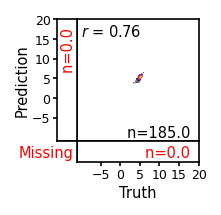

In [9]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/2nd_vae_seq_nor_package_correlation_train.pdf',dpi=300,bbox_inches='tight')

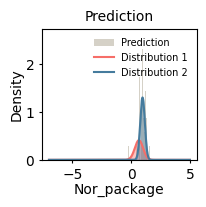

In [10]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/2nd_vae_seq_nor_package_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [11]:
AA = test_df[array].values
X = test_df.drop(columns=[array,'Y--nor_package'])
Y = test_df['Y--nor_package'].values
preds_df = predict(model, X,array, Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

TypeError: predict() missing 1 required positional argument: 'array'

In [ ]:
x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/2nd_vae_seq_nor_package_correlation_test.pdf',dpi=300,bbox_inches='tight')

In [ ]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 2 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-7, 5, 100000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/2nd_vae_seq_nor_package_distribution_test.pdf',dpi=300,bbox_inches='tight')